MSE: 3.5079187202152915
RMSE: 1.8729438646727488
R-squared: 0.9715


/var/folders/d4/868x7ffd6jb4lhp203myrtkc0000gn/T/ipykernel_69595/890062652.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2021['Differenced MA'] = data_2021['MA for 5 days'].diff().dropna()
/Users/Andy/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Andy/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Andy/opt/miniconda

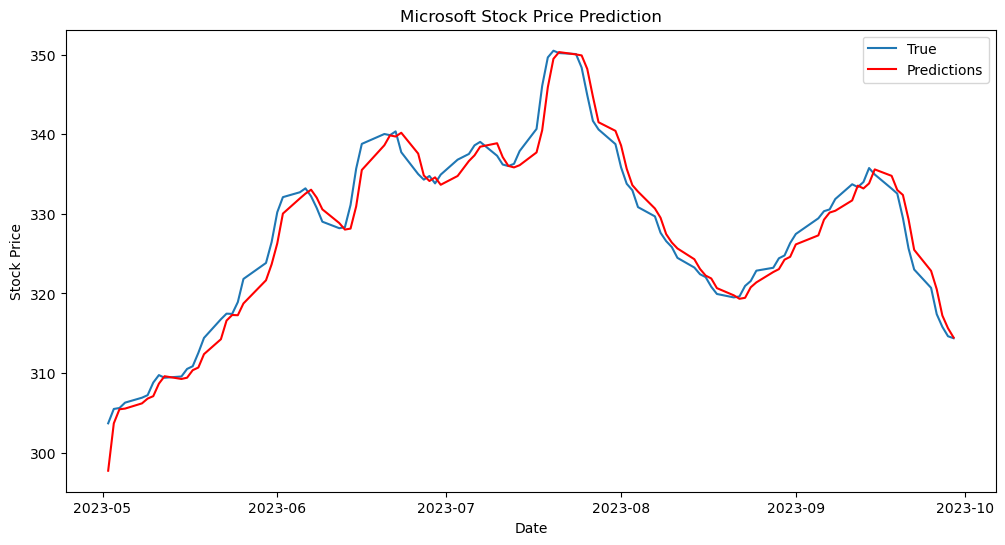

In [2]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

# Load and preprocess the data
data = pd.read_csv('MSFT.csv')
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Compute 5-day moving average
data['MA for 5 days'] = data['Close'].rolling(5).mean()
data_2021 = data['2021-09-01':]

train_data = data_2021['MA for 5 days'].iloc[:int(0.6*len(data_2021))]
val_data = data_2021['MA for 5 days'].iloc[int(0.6*len(data_2021)):int(0.8*len(data_2021))]
test_data = data_2021['MA for 5 days'].iloc[int(0.8*len(data_2021)):]

data_2021['Differenced MA'] = data_2021['MA for 5 days'].diff().dropna()

# Adjust training, validation, and test data to use the differenced series
train_data_diff = data_2021['Differenced MA'].iloc[1:int(0.6*len(data_2021))]
test_data_diff = data_2021['Differenced MA'].iloc[int(0.8*len(data_2021)):]

# Train ARIMA on the differenced series
model = ARIMA(train_data_diff, order=(1,0,0))
model_fit = model.fit()

# Forecast using the ARIMA model
forecast_diff = model_fit.forecast(steps=len(test_data_diff))

# Revert differencing on the forecast to get back to original scale
forecast_original = data_2021['MA for 5 days'].iloc[int(0.8*len(data_2021))-1:-1].values + forecast_diff

# Compute the performance metrics using the original test data
mse = mean_squared_error(test_data, forecast_original)
rmse = sqrt(mse)
r2 = r2_score(test_data, forecast_original)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2:.4f}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data, label="True")
plt.plot(test_data.index, forecast_original, label="Predictions", color='red')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()